# Gaussian Processes and 'Non-parametric' Bayes

##### Keywords: normal distribution, multivariate normal, marginal, conditional, priors, correlation, covariance, kernel, posterior, posterior predictive, infinite-basis, mercer's theorem, gaussian process, regression, kernelized regression, kernel trick, representer theorem

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
from sklearn.gaussian_process import GaussianProcess
from sklearn.cross_validation import train_test_split


//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## A quick primer on gaussian multivariate gaussians

* EQUATION A: For a multivariate gaussian the distribution is:

$$p(x \mid \mu, \Sigma) = (2\pi)^{-n/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

* EQUATION B: marginals of multivariate normal distributions are normal

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

* EQUATION C: conditionals of multivariate normals are normal

$$p(x \mid y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

Another way of looking at these is provided in Murphy Chapter 4:

![](images/gcondmarg.png)

## A problem with parametrics

In general, parametrization restricts the class of functions we use: for example, linear regression might use linear coefficients and just $x_i$ or a polynomial basis $x_i, x_i^2, ..$. If our data is not well modeled by our choices, we might underfit. Increasing flexibility (such as by making higher order polynomials in the regression) might lead to overfitting.

This is not the only place where parametrics may not be expressive enough. Consider for example a somewhat periodic time series with a more complex behavior and correlation structure than we find, for example, in a time series model, for example, in the not so fake global warming CO2 time series below:

![](images/gpco21.png)

A second approach might be to consider every possible function rather than making such a model restriction, and associate a prior probability with this function. For example, we might assign smoother functions higher prior probability. But how are we possibly going to calculate over an uncountably infinite set of functions in finite time?

Lets keep that thought in the back of our minds and consider linear regression.

## Linear regression and the Dual representation

Let us consider Bayesian Linear regression of N points in D dimensions:

$$y = f(X) + \epsilon, \\
\epsilon \sim N(0,\sigma^2), \\
f(X) = X^{T}w, w \sim N(0,\Sigma)$$

where the noise variance $\sigma^2$ is known.

In this case the posterior is given as:

$$ p(w | X,y) \sim N(\frac{1}{\sigma^2} A^{-1}Xy, A^{-1})$$

where 

$$ A = \frac{1}{\sigma^2}XX^T + \Sigma^{-1} $$

and the posterior predictive distribution (the conditional of $f(x_*)$ given $y$ is given by:

$$p(f(x_*) | x_* , X, y) = N(\frac{1}{\sigma^2}x_*^TA^{-1}Xy, x_*^T A^{-1}x_*).$$

ie the predictive distribution is a gaussian with a mean given by the posterior mean of the weights multiplied by the test input, and variance given by a quadratic form of the test input and the posterior predictive covariance matrix.

If you want the posterior predictive of $y_*$, just add $\sigma^2$ to the variance above.

We can show that we can rewrite the above posterior predictive as:

$$p(f(x_*) | x_* , X, y) = N(x_*^T\Sigma X^T(K + \sigma^2 I)^{-1}y, x_*^T\Sigma x_* - x_*^T\Sigma X^T(K + \sigma^2I)^{-1}X\Sigma x_*)$$

where

$$ K = X \Sigma X^T $$

which is of size N x N.

Notice now that the features only appear in the combination 

$$\kappa(x,x') = x^T \Sigma x',$$

thus leading to writing the posterior predictive as

$$ p(f(x_*) | x_* , X, y) = N\left(\kappa(x_*,X) \left(\kappa(X^T,X) + \sigma^2 I\right)^{-1}y,\,\,\, \kappa(x_*,x_*) - \kappa(x_*,X^T)\left(\kappa(X^T,X) + \sigma^2 I\right)^{-1} \kappa(X^T,x_*) \right)$$

The function $\kappa$ is called the kernel, and this formulation is known as the dual representation of bayesian ordinary linear regression (one could define this formalism for frequentist OLS as well, there is nothing bayesian about kernels).

Notice though that this kernel is degenerate, as it can have at most D non-zero eigenvalues. This reflects the fact that ordinary linear squares represents only a limited number of functions on which we can place priors. In other words, our model may not be expressive enough, and thus might underfit.

Does this formula look familiar from the gaussian formulae for a MVN used with a kernel in regression? Its identical actually. The plot thickens.

## Linear regression with basis function models and the Kernel view

The bayesian OLS model has limited expressiveness. One idea to deal with this is to project into a higher dimensional space, and apply the linear model to that space. For example, a scalar x could be projected into a polynomial space: $\phi(x) = (1, x, x^2, x^3, ...)$. 

This model is still linear in the parameters, and therefore analytically tractable. 

So let us now have

$$f(x) = \phi(x)^T w$$

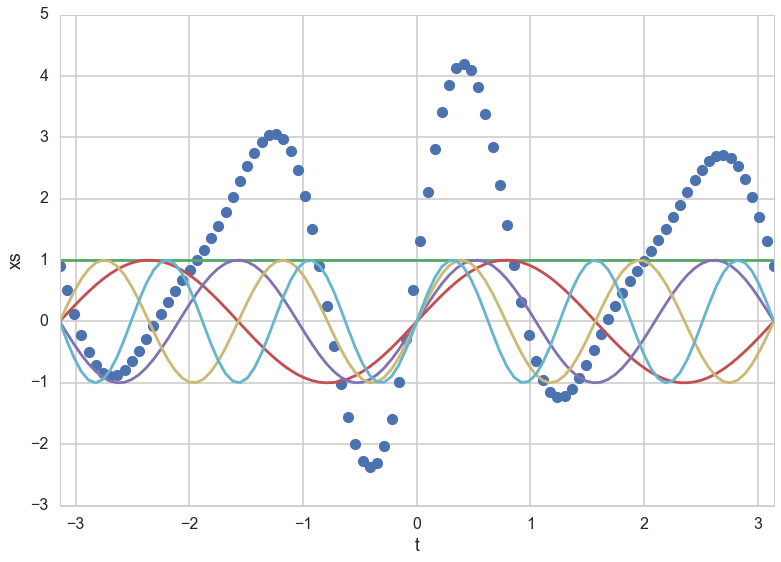

In [2]:
p = 5  # Number of inputs
t = np.linspace(-np.pi, np.pi, 100)

# Preallocate a matrix (make it a matrix of ones to account for beta_0):
XS = np.ones((100, p)) 
for ii in range(1, p):
    XS[:, ii] = np.sin((ii+1)*t)
beta = np.random.randn(p)
ff = np.dot(XS, beta)
plt.plot(t,ff,'o')
plt.plot(t,XS)

plt.xlim([-np.pi, np.pi])
plt.xlabel('t')
plt.ylabel('xs')


Let $\Phi(X)$ be the aggregation of columns $\phi(x)$ for all training set cases $x \in X$.

Then the posterior predictive, 
$$p(f(x_*) | x_* , X, y) = N(\frac{1}{\sigma^2}\phi_*^TA^{-1}\Phi y, \phi_*^T A^{-1}\phi_*).$$

where  $\phi_* = \phi(x_*)$ and 

$$ A = \frac{1}{\sigma^2}\Phi \Phi^T + \Sigma^{-1} $$


which can as before be written as

$$ N(\kappa(x_*,X) \left(\kappa(X^T,X) + \sigma^2 I\right)^{-1}y,\,\,\, \kappa(x_*,x_*) - \kappa(x_*,X^T)\left(\kappa(X^T,X) + \sigma^2 I\right)^{-1} \kappa(X^T,x_*) $$

where the kernel is now

$$\kappa(x,x') = \phi(x)^T \Sigma \phi(x')$$

As $\Sigma$ is positive definite we can define $\Sigma^{(1/2)}$ so that $(\Sigma^{(1/2)})^2 = \Sigma$. Then defining $\psi(x)  = \Sigma^{(1/2)} \phi(x)$ we can write

$$\kappa(x,x') = \psi(x)^T \psi(x')$$

If an algorithm is defined just in terms of inner products in input space then we can make the algorithm work in higher-dimensional feature space by replacing occurrences of those inner products by $\kappa(x,x')$. Indeed, this idea is used in classification, where we project into a higher dimensional space to make samples linearly separable under algorithms which use inner products, such as the SVM. This is known as the "kernel trick"

Notice now that carrying out the regression in feature space involves inverting the kernel, which is a N x N matrix, rather than the parameter matrix, which is likely to be smaller. Thus the kernelization comes at a price.

## From parametrics to non-parametrics

A parametric model has some finite set of parameters $w$. Conditional on these parameters, future observations are imdependent of past observations. Thus models may be thought of as information channels from the past observations to the future ones, with the parameters a bottleneck in this information channel.

If you have had any background in maths or physics, it will not have escaped your attention that one can extend a finite basis function expansion to an infinite one to express ANY function. For example, in calculating the electric field inside a cylindrical geometry, one expands the potential function in an infinite series of bessel functions. 

Thus one can consider feature space expansions as basis function expansions and ask the question: what happens when we allow an infinite number of basis functions, and thus an concomittant infinite set of parameters. This is the inverse problem of the electric field expansion: they key insight is that one could represent any function by such a basis set expansion (although some basis sets may more more appropriate to particular problems than others).

A non parametric model assumes that data cannot be represented in terms of a finite set of $w$. However, the above argument should convince you that one can think of the non-parametric approach to setting priors on functions as being defined in terms of an infinite dimensional $w$, with an infinite dimensional prior with 0 mean and an infinite sized covariance matrix.

From a information channel perspective, the amount of information that an infinite set of $w$ captures about the data grows as the amount of data grows. We have removed the bottleneck and this makes non-parametric models more flexible (and you might worry, in danger of overfitting).

## Gaussian Processes

Still, we havent dealt with the issue that there are infinitely many functions that we can use: how are we going to specify a prior on them as we did on the OLS, and how are we going to compute on them in finite time?

This is where we need the concept of a Gaussian Process, which is simply an infinite dimensional generalization of the Gaussian distribution. A probability distribution describes random scalars or vectors, while a stochastic process describes functions. 

Think of a function as a very long vector, one component at every point in an input x. Just like we thought of a model with an infinite number of parameters, you can now think of the function as an infinite vector. 

![](images/gproc.png)

So, let us assume an infinite dimensional index space with the index the postions $x_i$. Just like in the infinite basis set example before where we draw a vector $\overline{w}$ as a point in an infinite index space of integers, here we draw $\overline{f}$ from some 'infinite' gaussian distribution with some mean and some covariance function or kernel, which measures the similarity of any two points in this space, each of which map to a separate curve (thus the similarity of two curves). This then is the Gaussian Process, which we use to set a prior on the space of functions.  

Now the key insight is this: notice **in equation B for the marginal of a gaussian, only the covariance of the block of the matrix involving the unmarginalized dimensions matters! Thus "if you ask only for the properties of the function (you are fitting to the data) at a finite number of points, then inference in the Gaussian process will give you the same answer if you ignore the infinitely many other points, as if you would have taken them all into account!"(Rasmunnsen)**.

## Definition of Gaussian Process

So lets assume we have this function vector 
$ f=(f(x_1),...f(x_n))$. If, for ANY choice of input points, $(x_1,...,x_n)$, the marginal distribution over f:

$$P(F) = \int_{f \not\in F} P(f) df$$

is multi-variate Gaussian, then the distribution $P(f)$ over the function f is said to be a Gaussian Process. 

We write a Gaussian Process thus:

$$f(x) \sim \mathcal{GP}(m(x), k(x,x\prime))$$

where the mean and covariance functions can be thought of as the infinite dimensional mean vector and covariance matrix respectively. 

By this we mean that the function $f(x)$ is drawn from a gaussian process with some probability. 

Now the whole idea is that **a Gaussian Process defines a prior distribution over functions!** 

Once we have seen some data, this prior can be converted to a posterior over functions, thus restricting the set of functions that we can use based on the data. 

And based on the notion that the size of the "other" block of the matrix does not matter, we can do inference from a finite set of points rather than from an infinite one. This is what we did earlier.

The consequence of the finite point marginal distribution over functions being multi-variate gaussian is that any $m$ observations in an arbitrary data set, $y = {y_1,...,y_n=m}$ can always be represented as a single point sampled from some $m$-variate Gaussian distribution. Thus, we can work backwards to 'partner' a GP with a data set, by marginalizing over the infinitely-many variables that we are not interested in, or have not observed. 

It is often assumed for simplicity that the mean of this 'partnered' GP is zero in every dimension. Then, the only thing that relates one observation to another is the covariance function  $k(x_i, x_j)$. 

There are many choices of covariance functions but a popular choice is the 'squared exponential',

$$ k(x_i, x_j) = \sigma_f^2 exp( \frac{-(x_i-x_j)^2}{2l^2}) $$

where $\sigma_f^2$ is the maximum allowable covariance (or amplitude) and $l$ is the distance in the independent variable between $x_i$ and $x_j$. Note that this is a function solely of the independent variable, rather than the dependent one i.e. the only thing that impacts the corvariance function is the distances between each set of points. 

Thus, it is the covariance function that dictates if small length scales will be more likely, and large ones will be less, for example, and thus that wiffly functions are more probable, or that more rather than less samples drawn from the GP will be wiggly.

`Good portions of the following code are adapted from scikit-learn docs and Bios366 notebooks`

Define the kernel

In [3]:
# Basic squared exponential kernel, xi, xj are two points(vectors)
#the params are the sqrt(amplitude) and the length scale
def exponential_kernel(xi, xj, params): 
    amp=params[0]
    scale=params[1]
    return amp*amp * np.exp( -np.sum((xi - xj)**2)/(2*scale*scale) )

In [4]:
x_pred = np.linspace(0, 10, 1000)

Calculate covariance based on the kernel

In [5]:
# Covariance matrix for MV normal
covariance = lambda kernel, X1, X2, params: \
    np.array([[kernel(xi, x2i, params) for x2i in X2] for xi in X1])

In [7]:
xold=np.arange(0,10,0.5)
xtrain, xtest = train_test_split(xold)
xtrain = np.sort(xtrain)
xtest = np.sort(xtest)
#trainmask=np.array([True if i in xtrain else False for i in xold])
print(xtrain, xtest)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  6.   6.5  7.5  8.   9.5] [ 5.   5.5  7.   8.5  9. ]


## Regression using Gaussian Processes
(adapted from Bios366)

We saw the not-so-expressive OLS, and the more expressive finite basis function regressions earlier. Now lets see how we can regress with arbitrary functions. A Gaussian Process can be used to generate a regression given some noisy observations and thus provide a probabalistic estimate of the dependent variable at an unobserved value, $x^*$. 

Using a Gaussian process as a prior for our model, and a Gaussian as our data likelihood, then we can construct a Gaussian process posterior.

The likelihood takes the form:

$$y|f(x),x \sim \mathcal{N}(f(x), \sigma^2I) $$

where the infinite $f(x)$ takes the place of the parameters(while the GP likelihood conditions on a function, we are only interested in the function at locations where we have data), and $\sigma^2$ represents observation noise.

Our prior is: 
$$f(x) \sim \mathcal{GP}(m(x)=0, k(x,x\prime))$$

Multiplying an infinite normal prior with an infinite normal likelihood, we get an infinite normal posterior process:

$$f(x)|y \sim \mathcal{GP}(m_{post}, \kappa_{post}(x,x\prime)).$$

To calculate the posterior, and the posterior predictive, we can use the formula in equation C for the conditional of gaussians. The posterior distribution for f  is:

$$\begin{aligned}
m_{post} &= k(x\prime,x)[k(x,x) + \sigma^2I]^{-1}y \\
k_{post}(x,x\prime) &= k(x\prime,x\prime) - k(x\prime, x)[k(x,x) + \sigma^2I]^{-1}k(x,x\prime)
\end{aligned}$$

and the posterior predictive distribution for $f(x_*)$ for a test vector input $x_*$, given a training set X with values y for the GP is once again a gaussian given by equation C with a mean vector $m_*$ and covariance matrix $k_*$:

$$\begin{aligned}
m_* &= k(x_*,X)[k(X^T,X) + \sigma^2I]^{-1}y \\
k_* &= k(x_*,x_*) - k(x_*,X^T)[k(X^T,X) + \sigma^2I]^{-1}k(X^T,x_*)
\end{aligned}$$

The variance is a subtraction of two terms: the first being the prior covariance of the test set, and the second, the information that the data set gives us about the functions. It also does not depend on the observations, but rather the covariate inputs: this is a property of gaussians.
We can now, as before, very simply compute the predictive distribution of test targets y∗ by adding $\sigma^2 I$ to $k_*$.

Notice that the calculation once again involves inverting a NxN matrix as in the kernel space representation of regression. Thus there is "no free lunch",  calculating Gaussian processes without any approximations is only feasible for about a 1000 observations.

### The correspondence with kernelized regression

If you see the formulae above, there is an exact correspondence between the gaussian process (which is based on direct usage of gaussians in space) to the basis function regression (which is in feature space with the usage of gaussians for prior parameters) in the kernelized representation, as long as we identify the GP covariance function $k$ with the kernel function $\kappa(x,x') = \phi(x)^T \Sigma \phi(x')$. 

Thus, for any set of basis functions, we can compute a covariance function! And conversely, for any positive definite covariance function, we can associate a (possibly infinite) basis function expansion! This is known as Mercer's theorem.

Secondly, note that the posterior predictive mean is a linear combination of the observations y. Thus the Gaussian process (and basis function regression as well as OLS) can be thought of as a linear smoother of the training points. More on this later.

This mean may also be written as a linear combination of the kernel evaluated at the test points ( $k(x_*,X)$ ). Both of these are FINITE linear combinations. Thus Gaussian process can be represented as a finite linear expansion even though it comes from a possibly infinite basis function expansion (this is an example of the representer theorem). This makes intuitive sense because even though the GP defines a joint Gaussian distribution over all $f(X)$ variables corresponding to some infinite index set $X$, for making predictions at $x_∗$ we only care about the marginal at the test and training points, which is written purely in terms of quantities defined at those points.

Compared to OLS, in a GP we have assumed some spatial coherence (correlation) between the samples dictated by the covariance function, and conversely, OLS assumes a dirac delta correlation model. Spatial coherence could also meen temporal covariance of our covariate or index set is time, so the same mechanism can be used to model time correlations.

So now we have come full circle and can see how the (possibly infinite) basis function regression and even plain simple bayesian OLS regression are, with the choice of the covariance function as the kernel function, special cases of a gaussian process. 

Indeed, we can now employ GP terminology in understanding things like the bias-variance tradeoff and the expressivity of models vs overfitting, as well as and local vs global regression.

From now on we'll use the words covariance function or kernel interchangeably.

### Noiseless Regression

Lets start with the case in which there is no observational noise. In this case you can think of the regression process as generating functions from the prior, and then only choosing those which pass through the points at which the function is specified. In other words, the process of going from the prior to the posterior is the process of interpolattion of the training data. This might seem useless in the context of regression, but it is not: one application of noise-free GP regression is as a computationally cheap interpolator for a complex simulation, e.g. weather forecasting program.

Let's first implement the formula for a gaussian conditional:

In [8]:
# get conditional distribution for a gaussian
#use this to get the posterior  predictive mean and covariance on the
#x_new block
def conditional(x_new, x, f, cov_func, params):
    B = covariance(cov_func, x_new, x, params)
    C = covariance(cov_func, x, x, params)
    A = covariance(cov_func, x_new, x_new, params)
    Cinv=np.linalg.inv(C)
    mu = np.dot(np.dot(B, Cinv),f)
    sigma = A - np.dot(np.dot(B, Cinv), B.T)
    return mu.squeeze(), sigma.squeeze()

At this point lets choose a regression function

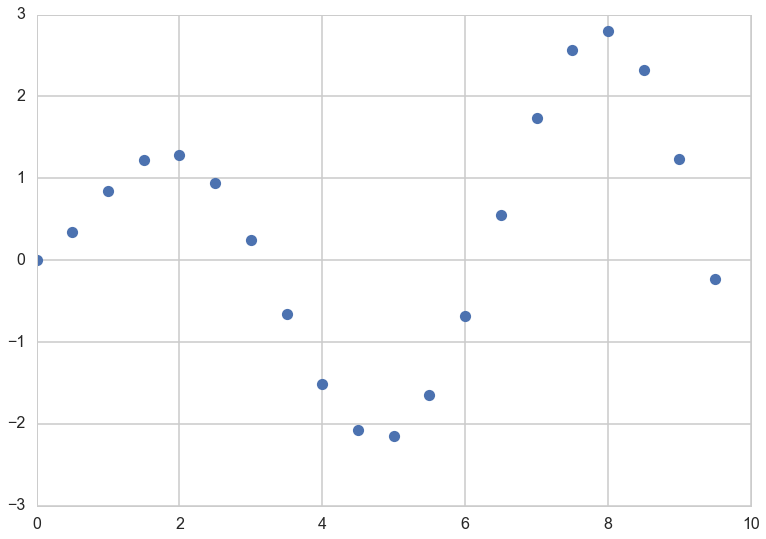

In [9]:
"""The function to predict."""
def f(x):
    return x**.5*np.sin(x)
plt.plot(xold, f(xold), 'o');

We use the conditional formula to calculate the posterior mean and covariance on a grid, given the results at some training points...

In [10]:
gp_params=[1,0.6]
munew, snew = conditional(x_pred, xtrain, f(xtrain), exponential_kernel, gp_params)
print(munew.shape, snew.shape)
signews = np.diagonal(snew)

(1000,) (1000, 1000)


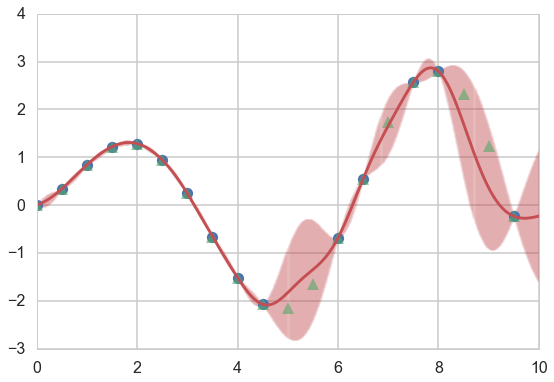

In [11]:
plt.figure(figsize=(9,6))
ax = plt.gca()
plt.plot(xtrain, f(xtrain), 'o');
plt.plot(xold, f(xold), '^', alpha=0.6);
plt.plot(x_pred, munew);
col=ax.lines[-1].get_color()
plt.errorbar(x_pred, munew, yerr=1.96*np.sqrt(signews), capsize=0, alpha=0.1, color=col);


We draw four arbitrary functions from the posterior:

In [12]:
f_more1 = np.random.multivariate_normal(munew, snew)
f_more2 = np.random.multivariate_normal(munew, snew)
f_more3 = np.random.multivariate_normal(munew, snew)
f_more4 = np.random.multivariate_normal(munew, snew)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


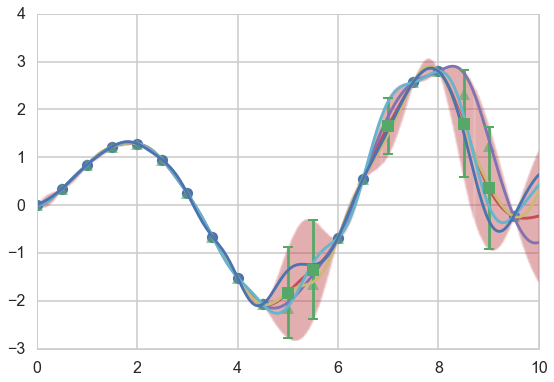

In [13]:
plt.figure(figsize=(9,6))
ax=plt.gca()
plt.plot(xtrain, f(xtrain), 'o');
plt.plot(xold, f(xold), '^', alpha=0.6);
plt.plot(x_pred, munew);
col=ax.lines[-1].get_color()
plt.errorbar(x_pred, munew, yerr=1.96*np.sqrt(signews), capsize=0, alpha=0.1, color=col);
plt.plot(x_pred, f_more1);
plt.plot(x_pred, f_more2);
plt.plot(x_pred, f_more3);
plt.plot(x_pred, f_more4);
mutestnn, stestnn = conditional(xtest, xtrain, f(xtrain), exponential_kernel, gp_params)
sigtestsnn = np.diagonal(stestnn)
plt.errorbar(xtest, mutestnn, yerr=1.96*np.sqrt(sigtestsnn), capsize=5, capthick=2, marker="s", ls='None');

### Noisy Regression

If the data is noisy, we can model each observations as though it were related to an underlying function $f(x)$ with a Gaussian noise model.

$$ y = f(x) + N(0,\sigma^2) $$

So given $n$ observations $y$, our objective is to predict $y^*$, not the actual $f(x_*)$. While the expected value of the predictions of either are identical, their variances differ due to observational noise. 


In [15]:
# Observations and noise
sigma_noise = 0.4
noise = np.random.normal(0, sigma_noise, xtrain.shape[0])
ytrain = f(xtrain) + noise



Let's plot our y

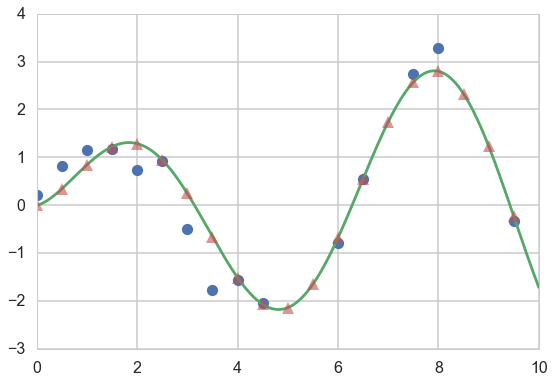

In [16]:
# plot
plt.figure(figsize=(9,6))
plt.plot(xtrain, ytrain, 'o')
plt.plot(x_pred, f(x_pred))
plt.plot(xold, f(xold), '^', alpha=0.6);


We alter the formula for the conditional to calculate the observational noise. Note that the variance here is the variance on $f(x_*)$, not that on $y$.

In [17]:
def conditional_noisy(x_new, x, y, sigma_noise, cov_func, params):
    B = covariance(cov_func, x_new, x, params)
    C = covariance(cov_func, x, x, params)
    C= C + sigma_noise*sigma_noise*np.eye(C.shape[0])
    Cinv=np.linalg.inv(C)
    A = covariance(cov_func, x_new, x_new, params)
    mu = np.dot(np.dot(B, Cinv),y)
    sigma = A - np.dot(np.dot(B, Cinv), B.T)
    return mu.squeeze(), sigma.squeeze()

In [19]:
mupost, spost = conditional_noisy(x_pred, xtrain, ytrain, sigma_noise, exponential_kernel, gp_params)
print(mupost.shape, spost.shape)
sigposts = np.diagonal(spost)

(1000,) (1000, 1000)


Draw from the noisy posterior

In [20]:
f_morep1 = np.random.multivariate_normal(mupost, spost)
f_morep2 = np.random.multivariate_normal(mupost, spost)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


Plot both the error on the $f(x_*)$ and $y$, as well as predictions on the training set.

(5,) (5, 5)


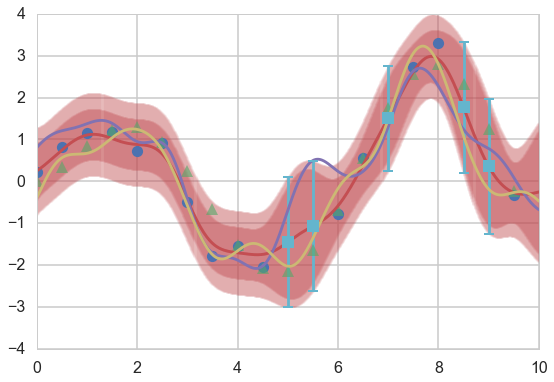

In [22]:
plt.figure(figsize=(9,6))
ax=plt.gca()
plt.plot(xtrain, ytrain, 'o');
plt.plot(xold, f(xold), '^', alpha=0.6);
plt.plot(x_pred, mupost);
col=ax.lines[-1].get_color()
plt.errorbar(x_pred, mupost, yerr=1.96*np.sqrt(sigposts), capsize=0, alpha=0.1, color=col);
col=ax.lines[-1].get_color()
plt.errorbar(x_pred, mupost, yerr=1.96*np.sqrt(sigposts+sigma_noise*sigma_noise), capsize=0, alpha=0.1, color=col);
plt.plot(x_pred, f_morep1);
plt.plot(x_pred, f_morep2);
#plt.plot(x_pred, y_morep3);
#plt.plot(x_pred, y_morep4);
mutest, stest = conditional_noisy(xtest, xtrain, ytrain, sigma_noise, exponential_kernel, gp_params)
print(mutest.shape, stest.shape)
stest = stest + sigma_noise*sigma_noise*np.eye(stest.shape[0])
sigtests = np.diagonal(stest)
plt.errorbar(xtest, mutest, yerr=1.96*np.sqrt(sigtests), capsize=5, capthick=2, marker="s", ls='None');

## Covariance Functions and the memory based nature of GPs

Non-parametric models are not summarised through parameters. Instead, they are memory based, dependent on the data, and summarized through a NxN covariance function or kernel. In other words, we must store an amount of information which increases with the size of the data.

You have probably seen other memory-based algorithms before, such as k-nearest neighbors, kernel density estimation, or localized regression of some form. In all of these algorithms, there is some parameter which plays the part of the controller of 'smoothing'.

We have already seen that GP's are linear smoothers: the posterior predictive GP mean can be written as a finite some of the training set y values, or for that matter as a finite sum of the kernels evaluated between the test and training set. In general, it is the hyperparameters in the kernel that control things like the length scale of smoothing, as we have seen, and allow one to move 'smoothly' between bias and variance extremes. 


The squared-exponential kernel is not the only kernel we can use. Indeed, one can make the squared-exponential kernel anisotropic to gain greater expressivity in our prior over functions, or use another kernel, such as for example, the Matern Kernel. (see a list on the wikipedia page: http://en.wikipedia.org/wiki/Gaussian_process) Kernels may be combined according to certain rules due to Mercer, which we shall not go into here.

### Mat&#232;rn Kernel

This is a very flexible kernel and is used quite often, especially in geostatistics and forestry.

$$k_{Matern}(d) = \frac{\sigma_f^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} d}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} d}{l}\right),$$

where $K_{\nu}$ is the modified bessel functction of the second kind.

The Mat&#232;rn covariance function has three parameters, each of which clearly controls one of three important properties of realizations.

The amplitude ($\sigma_f$) as before controls the normalization of the y scale, the length scale of changes ($l$) as before controls the scale of changes of the covariates (x). Finally, the Matern function has an additional roughness ($\nu$) parameter which controls the sharpness of the ridge of the covariance function and consequently the roughness (or smoothness) of realizations. This is the raison-de-etre for its existence.

In [23]:
#from https://www.mail-archive.com/scikit-learn-general@lists.sourceforge.net/msg09297.html
from scipy.special import kv # The modified bessel function of the second kind
from scipy.special import gamma # The gamma function
def matern(theta, d):
    """
    Matern correlation model.
    (Explicitly controls the degree of differentiability of the prediction.)

                                   n    / 1 / (2 ^ (nu - 1) * gamma(nu))    \
    theta, dx --> r(theta, dx) =  prod  | * abs(theta_i * d_i) ^ nu         |
                                 i = 1  \ * kv(nu, abs(theta_i * d_i))      /

    where kv is the modified bessel function of the second kind
    (from scipy.special).

    Parameters
    ----------
    theta : array_like
        An array with shape 1+1 (isotropic) or n+1 (anisotropic) giving the
        autocorrelation parameter(s) (theta, nu).

    dx : array_like
        An array with shape (n_eval, n_features) giving the componentwise
        distances between locations x and x' at which the correlation model
        should be evaluated.

    Returns
    -------
    r : array_like
        An array with shape (n_eval, ) with the values of the autocorrelation
        model.

    See also
    --------
    matern_once_differentiable, matern_twice_differentiable
    """

    theta = np.asanyarray(theta, dtype=np.float)
    d = np.asanyarray(d, dtype=np.float)

    if d.ndim > 1:
        n_features = d.shape[1]
    else:
        n_features = 1

    lth = theta.size
    if n_features > 1 and lth == 2:
        theta = np.hstack([np.repeat(theta[0], n_features), theta[1]])
    elif lth != n_features + 1:
        raise Exception("Length of theta must be 2 or %s" % (n_features + 1))
    else:
        theta = theta.reshape(1, lth)

    nu = theta[:, -1]
    td = 2. * np.sqrt(nu) \
            * theta[:, 0:-1].reshape(1, n_features) * np.abs(d)
    r = 1. / (2. ** (nu - 1.) * gamma(nu)) * td ** nu * kv(nu, td)
    r[td <= 1e-5] = 1. # The modified Bessel function of the second kind
                       # is badly defined around 0.
    r = np.prod(r, 1)

    return r


In [24]:
x = np.arange(-1,1,0.1)
ds = np.array([[xi - xj for xj in x] for xi in x])
dsr=ds.reshape(-1,1)
ds0=np.array([[xi - xj for xj in [0]] for xi in x])
dsr0=ds0.reshape(-1,1)

In [25]:
from matplotlib import cm
def do_plots(thetaps):
    matsr=matern(thetaps, dsr)
    mats0r=matern(thetaps, dsr0)
    mats=matsr.reshape(20,20)
    mats0=mats0r.reshape(20,1)
    plt.subplot(1,2,2)

    plt.contourf(x, x,  mats, origin='lower', extent=(-1,1,-1,1), 
                cmap=cm.bone)
    plt.colorbar()
    plt.subplot(1,2,1)
    plt.plot(x, mats0, 'k-')
    plt.ylabel('C(x,0)')

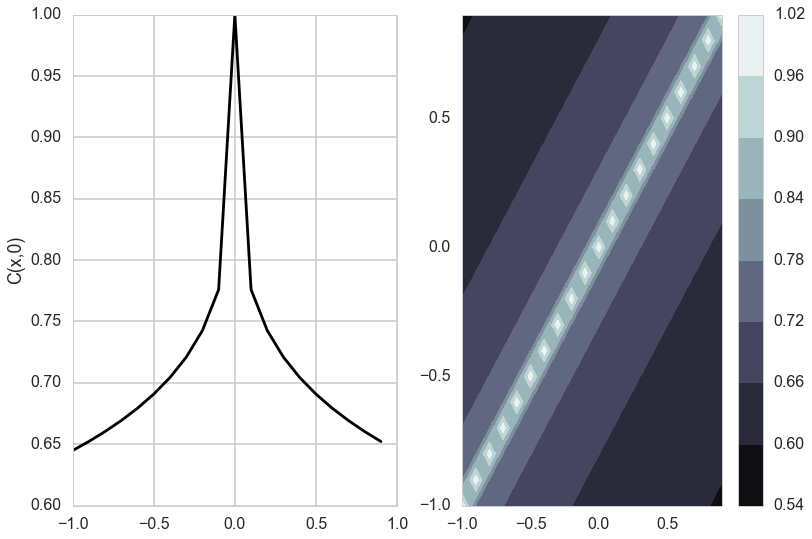

In [26]:
do_plots([0.01,0.1])


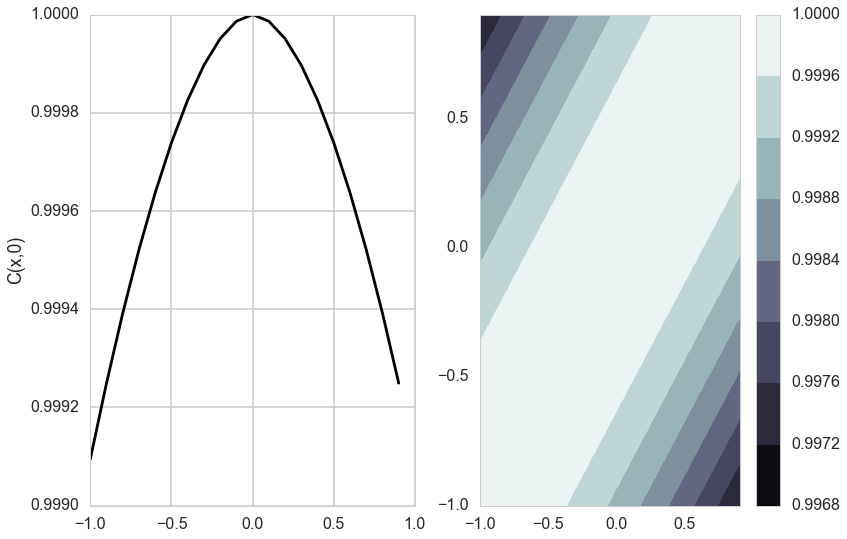

In [27]:
do_plots([0.01,1.0])


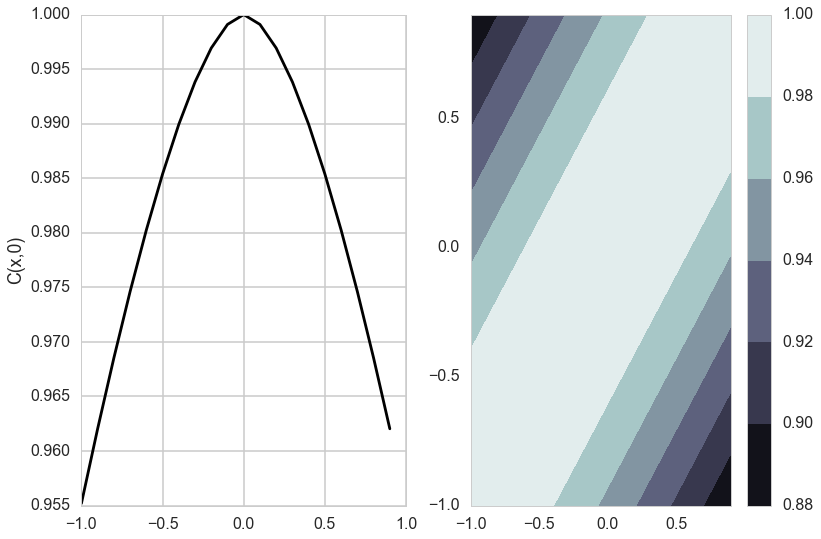

In [28]:
do_plots([0.1,1.0])


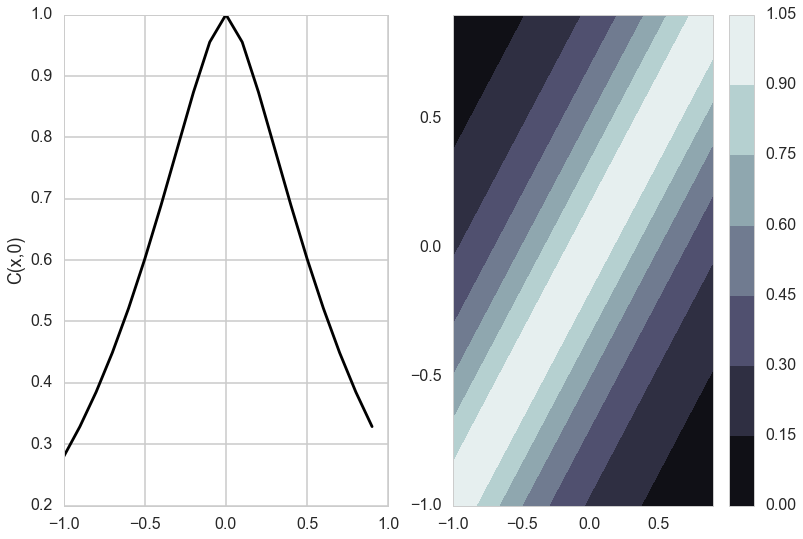

In [29]:
do_plots([1.0,1.0])
